In [1]:
import geostatspy.GSLIB as GSLIB                       # GSLIB utilies, visualization and wrapper
import geostatspy.geostats as geostats

%matplotlib inline
import os                                               # to set current working directory 
from sklearn.model_selection import train_test_split    # train and test data split by random selection of a proportion
from scipy.stats import norm                            # Gaussian distribution assumed for local uncertainty
import sys                                              # supress output to screen for interactive variogram modeling
import io                                               # set the working directory
import numpy as np                                      # arrays and matrix math
import pandas as pd                                     # DataFrames
import matplotlib.pyplot as plt                         # plotting
from matplotlib.pyplot import cm                        # color maps
from matplotlib.patches import Ellipse                  # plot an ellipse
import math                                             # sqrt operator                    
from ipywidgets import interactive                      # widgets and interactivity
from ipywidgets import widgets                            
from ipywidgets import Layout
from ipywidgets import Label
from ipywidgets import VBox, HBox

In [2]:
def simple_simple_krige(df,xcol,ycol,vcol,dfl,xlcol,ylcol,vario,skmean):
# load the variogram
    nst = vario['nst']; pmx = 9999.9
    cc = np.zeros(nst); aa = np.zeros(nst); it = np.zeros(nst)
    ang = np.zeros(nst); anis = np.zeros(nst)
    nug = vario['nug']; sill = nug 
    cc[0] = vario['cc1']; sill = sill + cc[0]
    it[0] = vario['it1']; ang[0] = vario['azi1']; 
    aa[0] = vario['hmaj1']; anis[0] = vario['hmin1']/vario['hmaj1'];
    if nst == 2:
        cc[1] = vario['cc2']; sill = sill + cc[1]
        it[1] = vario['it2']; ang[1] = vario['azi2']; 
        aa[1] = vario['hmaj2']; anis[1] = vario['hmin2']/vario['hmaj2'];    

# set up the required matrices
    rotmat, maxcov = geostats.setup_rotmat(nug,nst,it,cc,ang,pmx)    
    ndata = len(df); a = np.zeros([ndata,ndata]); r = np.zeros(ndata); s = np.zeros(ndata); rr = np.zeros(ndata)
    nest = len(dfl)

    est = np.zeros(nest); var = np.full(nest,sill); weights = np.zeros([nest,ndata])

# Make and solve the kriging matrix, calculate the kriging estimate and variance 
    for iest in range(0,nest):
        for idata in range(0,ndata):
            for jdata in range(0,ndata):
                a[idata,jdata] = geostats.cova2(df[xcol].values[idata],df[ycol].values[idata],df[xcol].values[jdata],df[ycol].values[jdata],
                                        nst,nug,pmx,cc,aa,it,ang,anis,rotmat,maxcov)
            r[idata] = geostats.cova2(df[xcol].values[idata],df[ycol].values[idata],dfl[xlcol].values[iest],dfl[ylcol].values[iest],
                                        nst,nug,pmx,cc,aa,it,ang,anis,rotmat,maxcov)
            rr[idata] = r[idata]
        
        s = geostats.ksol_numpy(ndata,a,r)    
        sumw = 0.0
        for idata in range(0,ndata):                          
            sumw = sumw + s[idata]
            weights[iest,idata] = s[idata]
            est[iest] = est[iest] + s[idata]*df[vcol].values[idata]
            var[iest] = var[iest] - s[idata]*rr[idata]
        est[iest] = est[iest] + (1.0-sumw)*skmean
    return est,var,weights

In [3]:
seed = 73073                                            # random number seed for train and test split and added error term
cmap = plt.cm.plasma                                    # color map
vmin = 0.0; vmax = 0.20                                 # feature min and max for plotting
error_std = 0.0                                         # error standard deviation
bins = 20

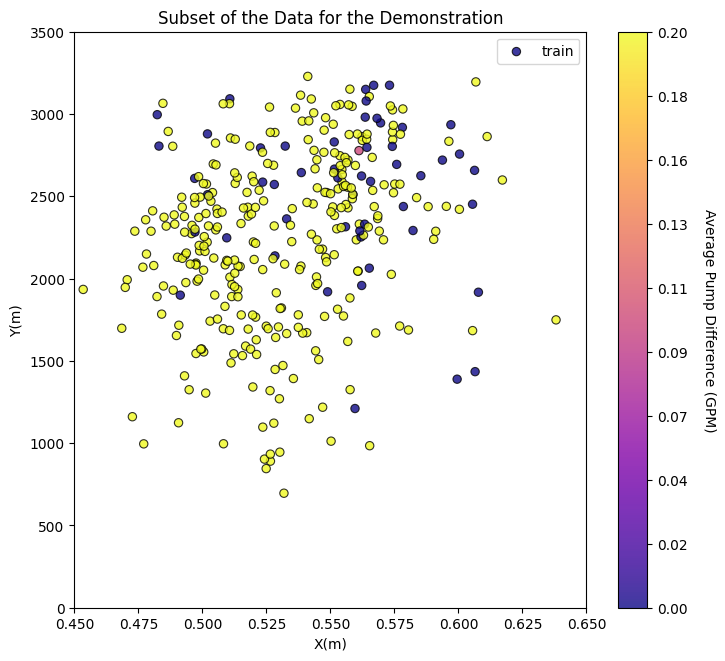

In [20]:
df_og = pd.read_csv('ImputedValues.csv')
df = pd.DataFrame()
df['X'] = df_og['Pressure Gradient (psi/ft) new']
df['Y'] = df_og['Avg Close Pressure']
df['Porosity'] = df_og['Avg Pump Difference']

df['Porosity'] = df['Porosity']+norm.rvs(0.0,error_std,random_state = seed,size=len(df))

plt.subplot(111)
im = plt.scatter(df['X'],df['Y'],c=df['Porosity'],marker='o',cmap=cmap,vmin=vmin,vmax=vmax,alpha=0.8,linewidths=0.8,
        edgecolors="black",label="train")
plt.title("Subset of the Data for the Demonstration")
plt.xlim([0.45,0.65]); plt.ylim([0,3500])
plt.xlabel('X(m)'); plt.ylabel('Y(m)'); plt.legend()
cbar = plt.colorbar(im, orientation="vertical", ticks=np.linspace(vmin, vmax, 10),format='%.2f')
cbar.set_label('Average Pump Difference (GPM)', rotation=270, labelpad=20)

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

In [29]:
import warnings; warnings.simplefilter('ignore')

# build the dashboard
style = {'description_width': 'initial'}
l = widgets.Text(value='                                              Simple Kriging, Michael Pyrcz, Associate Professor, The University of Texas at Austin',layout=Layout(width='950px', height='30px'))
nug = widgets.FloatSlider(min = 0, max = 1.0, value = 0.0, step = 0.1, description = 'nug',orientation='vertical',continuous_update=False,
                          layout=Layout(width='50px', height='200px'))
nug.style.handle_color = 'gray'
it1 = widgets.Dropdown(options=['Spherical', 'Exponential', 'Gaussian'],value='Spherical',continuous_update=False,
    description='Type1:',disabled=False,layout=Layout(width='180px', height='30px'), style=style)

azi = widgets.FloatSlider(min=0, max = 360, value = 45, step = 22.5, description = 'azi',continuous_update=False,
                        orientation='vertical',layout=Layout(width='80px', height='200px'))
azi.style.handle_color = 'gray'
hmaj1 = widgets.FloatSlider(min=0.01, max = 10000.0, value = 5000.0, step = 500.0, description = 'hmaj1',continuous_update=False,
                        orientation='vertical',layout=Layout(width='80px', height='200px'))
hmaj1.style.handle_color = 'gray'
hmin1 = widgets.FloatSlider(min = 0.01, max = 10000.0, value = 3000.0, step = 500.0, description = 'hmin1',continuous_update=False,
                        orientation='vertical',layout=Layout(width='80px', height='200px'))
hmin1.style.handle_color = 'gray'

ptest = widgets.FloatSlider(min = 0.01, max = 0.9, value = 100.0, step = 0.1, description = 'prop test',continuous_update=False,
                        orientation='vertical',layout=Layout(width='80px', height='200px'))
ptest.style.handle_color = 'gray'

ndata = widgets.IntSlider(min = 1, max = len(df), value = 100, step = 10, description = 'number data',continuous_update=False,
                        orientation='vertical',layout=Layout(width='80px', height='200px'))
ndata.style.handle_color = 'gray'

uikvar = widgets.HBox([nug,it1,azi,hmaj1,hmin1,ptest,ndata],)  

uipars = widgets.HBox([uikvar],) 
uik = widgets.VBox([l,uipars],)

# convenience function ot convert variogram model type to a integer
def convert_type(it):
    if it == 'Spherical': 
        return 1
    elif it == 'Exponential':
        return 2
    else: 
        return 3

# calculate the kriging-based uncertainty distributions and match truth values to percentiles and product plots
def f_make_krige(nug,it1,azi,hmaj1,hmin1,ptest,ndata):                      
    text_trap = io.StringIO()
    sys.stdout = text_trap
    it1 = convert_type(it1)
    
    df_og['Porosity'] = df_og['Avg Pump Difference']
    train, test = train_test_split(df_og[['Pressure Gradient (psi/ft) new', 'Porosity']], test_size=ptest, random_state=73073)
    
    nst = 1; xlag = 10; nlag = int(hmaj1/xlag); c1 = 1.0-nug
    vario = GSLIB.make_variogram(nug,nst,it1,c1,azi,hmaj1,hmin1) # make model object
    index_maj,h_maj,gam_maj,cov_maj,ro_maj = geostats.vmodel(nlag,xlag,azi,vario) # project the model in the major azimuth                                                  # project the model in the 135 azimuth
    index_min,h_min,gam_min,cov_min,ro_min = geostats.vmodel(nlag,xlag,azi+90.0,vario) # project the model in the minor azimuth
    skmean = np.average(train['Porosity'])              # calculate the input mean and sill for simple kriging
    sill = np.var(train['Porosity'])
    
    sk_est, sk_var, sk_weights =  simple_simple_krige(train,'X','Y','Porosity',test,'X','Y',vario,skmean=skmean) # data, esitmation locations
    sk_std = np.sqrt(sk_var*sill)                       # standardize estimation variance by the sill and convert to std. dev.

    
    percentiles = norm.cdf(test['Porosity'],sk_est,sk_std) # calculate the percentiles of truth in the uncertainty models
    test["Percentile"] = percentiles
    
    xlag = 10.0; nlag = int(hmaj1/xlag)                 # lags for variogram plotting
    
    plt.subplot(221)                                    # plot variograms
    plt.plot([0,hmaj1*1.5],[1.0,1.0],color = 'black')
    plt.plot(h_maj,gam_maj,color = 'black',label = 'Major ' + str(azi))    
    plt.plot(h_min,gam_min,color = 'black',label = 'Minor ' + str(azi+90.0))
    deltas = [22.5, 45, 67.5]; 
    ndelta = len(deltas); hd = np.zeros(ndelta); gamd = np.zeros(ndelta);
    color=iter(cm.plasma(np.linspace(0,1,ndelta)))
    for delta in deltas:
        index,hd,gamd,cov,ro = geostats.vmodel(nlag,xlag,azi+delta,vario);
        c=next(color)
        plt.plot(hd,gamd,color = c,label = 'Azimuth ' + str(azi+delta))
    plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
    plt.ylabel(r'$\gamma \bf(h)$')
    plt.title('Interpolated NSCORE Porosity Variogram Models')
    plt.xlim([0,hmaj1*1.5])
    plt.ylim([0,1.4])
    plt.legend(loc='upper left')
  
    plt.subplot(222)                                    # plot the train and test data
    im = plt.scatter(train['X'],train['Y'],c=train['Porosity'],marker='o',cmap=cmap,vmin=vmin,vmax=vmax,alpha=0.8,linewidths=0.8,
        edgecolors="black",label="train")
    plt.scatter(test['X'],test['Y'],c=test['Porosity'],marker='^',cmap=cmap,vmin=vmin,vmax=vmax,alpha=0.8,linewidths=0.8,
        edgecolors="black",label="test")
    plt.title("Training and Testing Data")
    plt.xlim([0,1000]); plt.ylim([0,1000])
    plt.xlabel('X(m)'); plt.ylabel('Y(m)'); plt.legend()
    cbar = plt.colorbar(im, orientation="vertical", ticks=np.linspace(vmin, vmax, 10),format='%.2f')
    cbar.set_label('Porosity (fraction)', rotation=270, labelpad=20)
    plt.grid(True)
    
    fraction_in = np.zeros(bins)                        # calculate and plot the accuracy plot
    p_intervals = np.linspace(0.0,1.0,bins)
    for i,p in enumerate(p_intervals): 
        test_result = (test['Percentile'] > 0.5-0.5*p) & (test['Percentile'] < 0.5+0.5*p)
        fraction_in[i] = test_result.sum()/len(test)

    plt.subplot(223)    
    plt.scatter(p_intervals,fraction_in,c='grey',edgecolor='black',marker='o',alpha=0.8,zorder=100)
    plt.plot([0.0,1.0],[0.0,1.0],c='grey',zorder=100,ls='--')
    plt.fill_between([0.1,1],[0,0.9],[0,0],color='red',alpha=0.2,zorder=1)
    plt.fill_between([0,0.9],[0.1,1.0],[1.0,1.0],color='yellow',alpha=0.2,zorder=1)
    plt.xlim([0.0,1.0]); plt.ylim([0,1.0])
    plt.annotate('Accurate and Precise',xy=[0.3,0.3],rotation=40,fontsize=16)
    plt.annotate('Inaccurate and Imprecise',xy=[0.4,0.1],rotation=40,fontsize=16)
    plt.annotate('Accurate and Imprecise',xy=[0.2,0.5],rotation=40,fontsize=16)
    plt.title('Uncertainty Model at Unknown Location')
    plt.xlabel('Probability Interval'); plt.ylabel('Fraction In the Interval')
    
    plt.subplot(224)                                      # plot the testing percentiles with the training data
    plt.scatter(train['X'],train['Y'],s=20,c='black',marker='o',cmap=cmap,vmin=vmin,vmax=vmax,alpha=0.8,linewidths=0.8,
        edgecolors="black",label="train")
    im = plt.scatter(test['X'],test['Y'],s=80.0,c=test['Percentile'],marker='^',cmap=cmap,vmin=0.0,vmax=1.0,alpha=0.8,linewidths=0.8,
        edgecolors="black",label="test")
    plt.title("Cross Validation Percentiles")
    plt.xlim([0,1000]); plt.ylim([0,1000])
    plt.xlabel('X(m)'); plt.ylabel('Y(m)'); plt.legend()
    cbar = plt.colorbar(im, orientation="vertical", ticks=np.linspace(0.0, 1.0, 10),format='%.2f')
    cbar.set_label('Porosity Truth Percentile (fraction)', rotation=270, labelpad=20)    
    plt.grid(True) 

    plt.subplots_adjust(left=0.0, bottom=0.0, right=1.8, top=2.2, wspace=0.3, hspace=0.3)
    plt.show()
    
# connect the function to make the samples and plot to the widgets    
interactive_plot = widgets.interactive_output(f_make_krige, {'nug':nug, 'it1':it1, 'azi':azi, 'hmaj1':hmaj1, 'hmin1':hmin1, 'ptest':ptest, 'ndata':ndata})
interactive_plot.clear_output(wait = True)

KeyError: 'X'